In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.svm import SVC
from sklearn.metrics import classification_report, accuracy_score


data = pd.read_csv('AQI_EXCEL.csv')
print(data.head())
print(data.describe())


   rank              city  avg  jan  feb  mar  apr  may  jun  jul  aug  sep  \
0     1  Begusarai, India  223  413  337  250  258  209  205  131  115  100   
1     2      Patna, India  212  354  297  225  230  169  183   82  100   84   
2     3    Saharsa, India  207  418  344  238  220  167  149   85   93   91   
3     4  New Delhi, India  205  325  244  167  181  175  124   70  110   91   
4     5      Noida, India  201  304  212  154  187  176  129   70  125  118   

   oct  nov  dec  
0  114  298  249  
1  136  402  277  
2  110  282  292  
3  210  405  352  
4  237  367  338  
             rank          avg
count  5377.00000  5377.000000
mean   2689.00000    32.171657
std    1552.35053    27.075191
min       1.00000     1.000000
25%    1345.00000    16.000000
50%    2689.00000    26.000000
75%    4033.00000    37.000000
max    5377.00000   223.000000


In [2]:
# Preprocessing function
def categorize_aqi(value):
    if value <= 50:
        return "Good"
    elif value <= 100:
        return "Moderate"
    elif value <= 150:
        return "Unhealthy for Sensitive Groups"
    elif value <= 200:
        return "Unhealthy"
    elif value <= 300:
        return "Very Unhealthy"
    else:
        return "Hazardous"

data['AQI_Category'] = data['avg'].apply(categorize_aqi)

monthly_columns = ['jan', 'feb', 'mar', 'apr', 'may', 'jun',
                   'jul', 'aug', 'sep', 'oct', 'nov', 'dec']
features = monthly_columns
target = 'AQI_Category'


data[features] = data[features].replace('-', np.nan)
data[features] = data[features].apply(pd.to_numeric, errors='coerce')


data[features] = data[features].fillna(data[features].median())

le = LabelEncoder()
data[target] = le.fit_transform(data[target])



In [3]:
data.head()

,rank,city,avg,jan,feb,mar,apr,may,jun,jul,aug,sep,oct,nov,dec,AQI_Category
0,1,"Begusarai, India",223,413.0,337.0,250.0,258.0,209.0,205.0,131.0,115.0,100.0,114.0,298.0,249.0,4
1,2,"Patna, India",212,354.0,297.0,225.0,230.0,169.0,183.0,82.0,100.0,84.0,136.0,402.0,277.0,4
2,3,"Saharsa, India",207,418.0,344.0,238.0,220.0,167.0,149.0,85.0,93.0,91.0,110.0,282.0,292.0,4
3,4,"New Delhi, India",205,325.0,244.0,167.0,181.0,175.0,124.0,70.0,110.0,91.0,210.0,405.0,352.0,4
4,5,"Noida, India",201,304.0,212.0,154.0,187.0,176.0,129.0,70.0,125.0,118.0,237.0,367.0,338.0,4


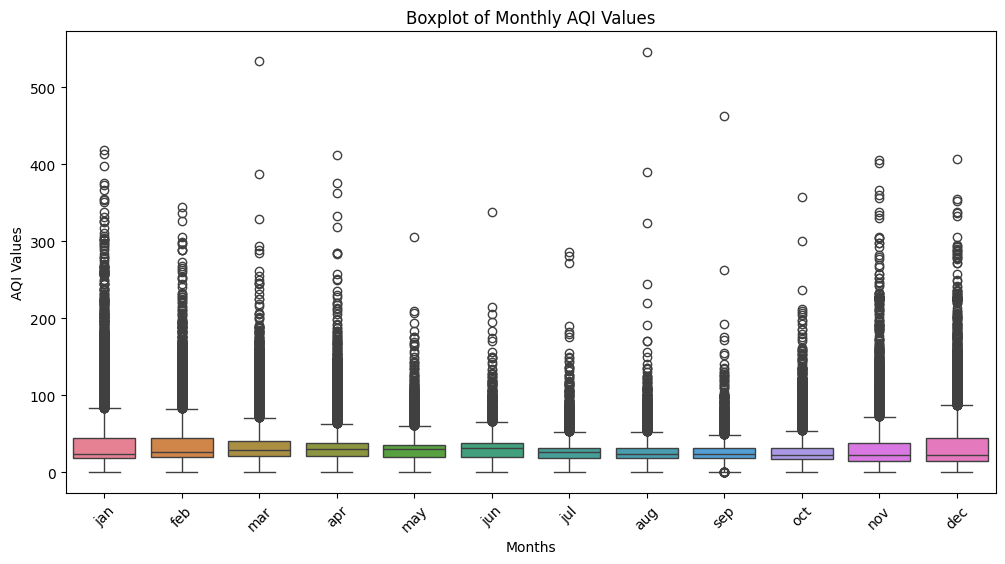

In [4]:
# boxplot before removing outliers
plt.figure(figsize=(12, 6))
sns.boxplot(data=data[monthly_columns])
plt.xticks(rotation=45)  # Rotate x-axis labels for better readability
plt.title("Boxplot of Monthly AQI Values")
plt.xlabel("Months")
plt.ylabel("AQI Values")
plt.show()

In [5]:

Q1 = data[monthly_columns].quantile(0.25)
Q3 = data[monthly_columns].quantile(0.75)
IQR = Q3 - Q1

lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR


data[monthly_columns] = data[monthly_columns].clip(lower_bound, upper_bound, axis=1)



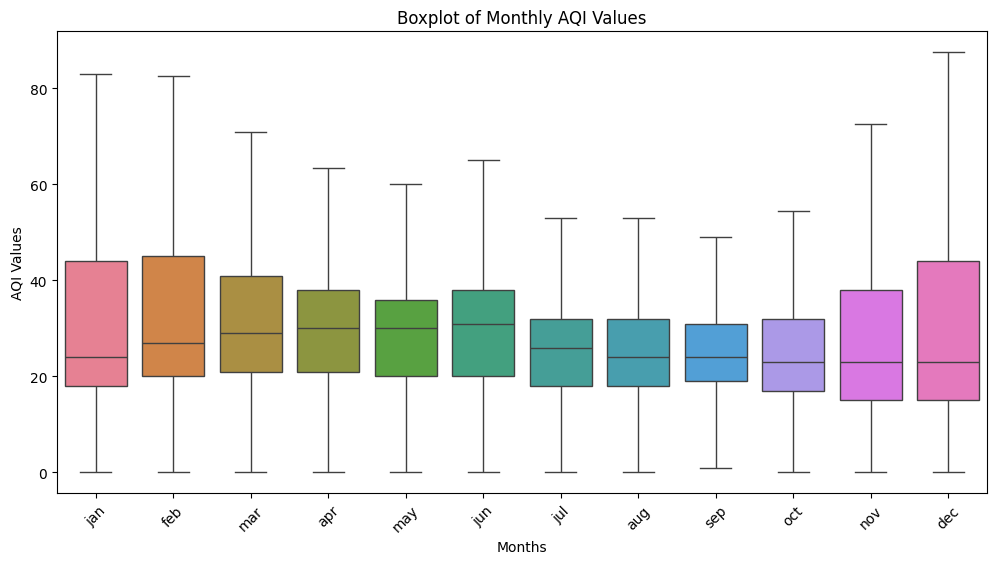

In [6]:
# boxplot after handling outliers
plt.figure(figsize=(12, 6))
sns.boxplot(data=data[monthly_columns])
plt.xticks(rotation=45)  # Rotate x-axis labels for better readability
plt.title("Boxplot of Monthly AQI Values")
plt.xlabel("Months")
plt.ylabel("AQI Values")
plt.show()

In [7]:

X = data[features]
y = data[target]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Model Training
def train_and_evaluate_model(model, model_name):
    print(f"\nTraining {model_name}...")
    model.fit(X_train_scaled, y_train)
    y_pred = model.predict(X_test_scaled)
    print(f"Accuracy: {accuracy_score(y_test, y_pred):.2f}")

    # Ensure all possible categories are included in the classification report
    all_classes = np.unique(np.concatenate([y_train, y_test]))
    print(classification_report(y_test, y_pred, labels=all_classes, target_names=le.classes_))



In [8]:
# Logistic Regression
lr_model = LogisticRegression(random_state=42)
train_and_evaluate_model(lr_model, "Logistic Regression")


Training Logistic Regression...
Accuracy: 0.95
                                precision    recall  f1-score   support

                          Good       0.99      0.99      0.99       897
                      Moderate       0.82      0.84      0.83       140
                     Unhealthy       0.00      0.00      0.00         4
Unhealthy for Sensitive Groups       0.55      0.53      0.54        34
                Very Unhealthy       0.00      0.00      0.00         1

                      accuracy                           0.95      1076
                     macro avg       0.47      0.47      0.47      1076
                  weighted avg       0.95      0.95      0.95      1076



/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no pre

In [9]:
# Random Forest Classifier
rf_model = RandomForestClassifier(n_estimators=20, random_state=42)
train_and_evaluate_model(rf_model, "Random Forest")


Training Random Forest...
Accuracy: 0.96
                                precision    recall  f1-score   support

                          Good       0.99      0.99      0.99       897
                      Moderate       0.86      0.89      0.88       140
                     Unhealthy       0.00      0.00      0.00         4
Unhealthy for Sensitive Groups       0.67      0.65      0.66        34
                Very Unhealthy       0.00      0.00      0.00         1

                      accuracy                           0.96      1076
                     macro avg       0.50      0.51      0.50      1076
                  weighted avg       0.96      0.96      0.96      1076



/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [10]:
# Support Vector Machine
svm_model = SVC(kernel='rbf', random_state=42)
train_and_evaluate_model(svm_model, "Support Vector Machine")


Training Support Vector Machine...
Accuracy: 0.95
                                precision    recall  f1-score   support

                          Good       0.99      0.99      0.99       897
                      Moderate       0.75      0.95      0.84       140
                     Unhealthy       0.00      0.00      0.00         4
Unhealthy for Sensitive Groups       0.00      0.00      0.00        34
                Very Unhealthy       0.00      0.00      0.00         1

                      accuracy                           0.95      1076
                     macro avg       0.35      0.39      0.37      1076
                  weighted avg       0.92      0.95      0.94      1076



/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [11]:
#Gradient boosting classifier
gb_model = GradientBoostingClassifier(n_estimators=300, learning_rate=0.1, max_depth=4, random_state=42)
train_and_evaluate_model(gb_model, "Gradient Boosting Classifier")



Training Gradient Boosting Classifier...
Accuracy: 0.96
                                precision    recall  f1-score   support

                          Good       0.99      0.99      0.99       897
                      Moderate       0.86      0.90      0.88       140
                     Unhealthy       0.00      0.00      0.00         4
Unhealthy for Sensitive Groups       0.67      0.71      0.69        34
                Very Unhealthy       0.00      0.00      0.00         1

                      accuracy                           0.96      1076
                     macro avg       0.50      0.52      0.51      1076
                  weighted avg       0.96      0.96      0.96      1076



/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))



Random Forest Model Performance:
Accuracy: 0.96

Classification Report:
                                precision    recall  f1-score   support

                          Good       0.99      0.99      0.99       897
                      Moderate       0.86      0.89      0.88       140
                     Unhealthy       0.00      0.00      0.00         4
Unhealthy for Sensitive Groups       0.67      0.65      0.66        34
                Very Unhealthy       0.00      0.00      0.00         1

                      accuracy                           0.96      1076
                     macro avg       0.50      0.51      0.50      1076
                  weighted avg       0.96      0.96      0.96      1076



/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


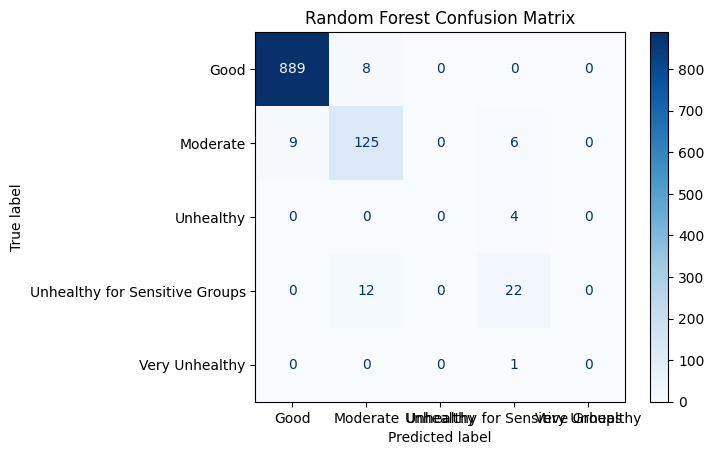

In [12]:
#prediction on random forest model
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

y_pred_rf = rf_model.predict(X_test_scaled)

print("\nRandom Forest Model Performance:")
print(f"Accuracy: {accuracy_score(y_test, y_pred_rf):.2f}")
print("\nClassification Report:")
print(classification_report(y_test, y_pred_rf, target_names=le.classes_))

# Confusion Matrix
cm = confusion_matrix(y_test, y_pred_rf)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=le.classes_)
disp.plot(cmap="Blues", values_format='d')
plt.title("Random Forest Confusion Matrix")
plt.show()



Training Logistic Regression...
Accuracy: 0.95


/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no pre

                                precision    recall  f1-score   support

                          Good       0.99      0.99      0.99       897
                      Moderate       0.82      0.84      0.83       140
                     Unhealthy       0.00      0.00      0.00         4
Unhealthy for Sensitive Groups       0.55      0.53      0.54        34
                Very Unhealthy       0.00      0.00      0.00         1

                      accuracy                           0.95      1076
                     macro avg       0.47      0.47      0.47      1076
                  weighted avg       0.95      0.95      0.95      1076


Training Support Vector Machine...
Accuracy: 0.95
                                precision    recall  f1-score   support

                          Good       0.99      0.99      0.99       897
                      Moderate       0.75      0.95      0.84       140
                     Unhealthy       0.00      0.00      0.00         4
Unhealthy

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Accuracy: 0.96
                                precision    recall  f1-score   support

                          Good       0.99      0.99      0.99       897
                      Moderate       0.86      0.90      0.88       140
                     Unhealthy       0.00      0.00      0.00         4
Unhealthy for Sensitive Groups       0.68      0.68      0.68        34
                Very Unhealthy       0.00      0.00      0.00         1

                      accuracy                           0.96      1076
                     macro avg       0.51      0.51      0.51      1076
                  weighted avg       0.96      0.96      0.96      1076


Logistic Regression Model Performance:
Accuracy: 0.95

Classification Report:
                                precision    recall  f1-score   support

                          Good       0.99      0.99      0.99       897
                      Moderate       0.82      0.84      0.83       140
                     Unhealthy       0

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/m

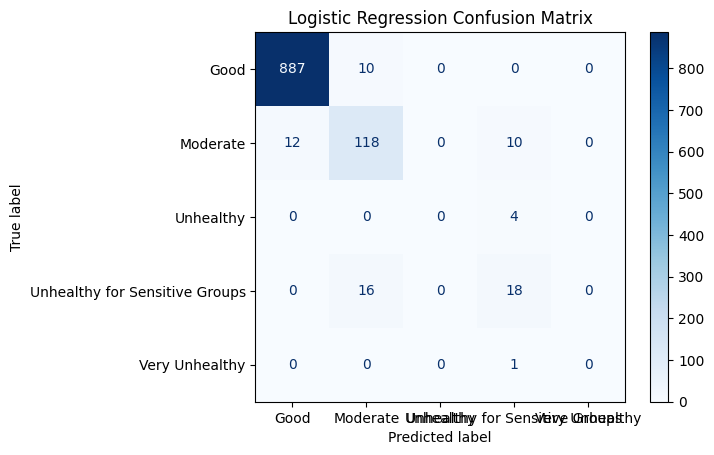


Support Vector Machine Model Performance:
Accuracy: 0.95

Classification Report:
                                precision    recall  f1-score   support

                          Good       0.99      0.99      0.99       897
                      Moderate       0.75      0.95      0.84       140
                     Unhealthy       0.00      0.00      0.00         4
Unhealthy for Sensitive Groups       0.00      0.00      0.00        34
                Very Unhealthy       0.00      0.00      0.00         1

                      accuracy                           0.95      1076
                     macro avg       0.35      0.39      0.37      1076
                  weighted avg       0.92      0.95      0.94      1076



/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


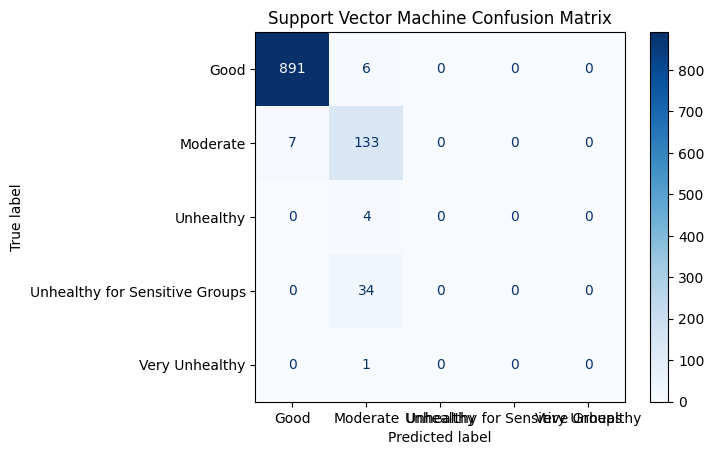


Gradient Boosting Classifier Model Performance:
Accuracy: 0.96

Classification Report:
                                precision    recall  f1-score   support

                          Good       0.99      0.99      0.99       897
                      Moderate       0.86      0.90      0.88       140
                     Unhealthy       0.00      0.00      0.00         4
Unhealthy for Sensitive Groups       0.68      0.68      0.68        34
                Very Unhealthy       0.00      0.00      0.00         1

                      accuracy                           0.96      1076
                     macro avg       0.51      0.51      0.51      1076
                  weighted avg       0.96      0.96      0.96      1076



/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


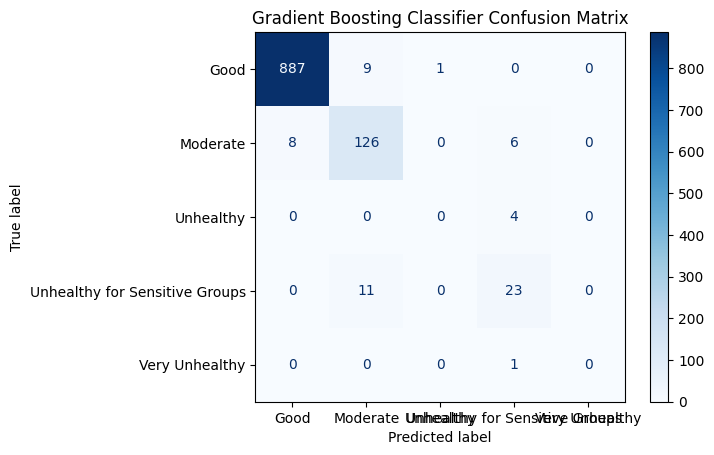

In [13]:
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.svm import SVC


svm_model = SVC(kernel='rbf', random_state=42)
gb_model = GradientBoostingClassifier(n_estimators=100, random_state=42)


train_and_evaluate_model(lr_model, "Logistic Regression")
train_and_evaluate_model(svm_model, "Support Vector Machine")
train_and_evaluate_model(gb_model, "Gradient Boosting Classifier")

y_pred_lr = lr_model.predict(X_test_scaled)
y_pred_svm = svm_model.predict(X_test_scaled)
y_pred_gb = gb_model.predict(X_test_scaled)

# Model Performance Evaluation
def evaluate_model_performance(y_test, y_pred, model_name):
    print(f"\n{model_name} Model Performance:")
    print(f"Accuracy: {accuracy_score(y_test, y_pred):.2f}")
    print("\nClassification Report:")
    print(classification_report(y_test, y_pred, target_names=le.classes_))

    # Confusion Matrix
    cm = confusion_matrix(y_test, y_pred)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=le.classes_)
    disp.plot(cmap="Blues", values_format='d')
    plt.title(f"{model_name} Confusion Matrix")
    plt.show()


evaluate_model_performance(y_test, y_pred_lr, "Logistic Regression")
evaluate_model_performance(y_test, y_pred_svm, "Support Vector Machine")
evaluate_model_performance(y_test, y_pred_gb, "Gradient Boosting Classifier")

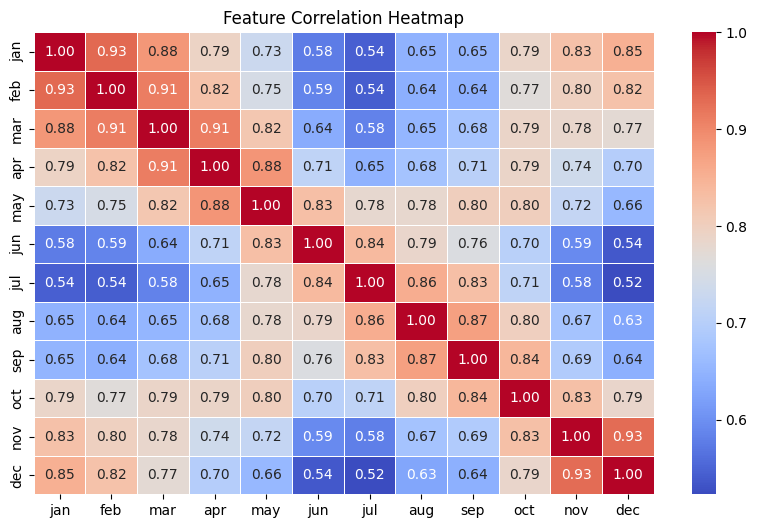

In [14]:
#Heatmap - Correlation Matrix
plt.figure(figsize=(10, 6))
sns.heatmap(data[features].corr(), annot=True, cmap="coolwarm", fmt=".2f", linewidths=0.5)
plt.title("Feature Correlation Heatmap")
plt.show()



<ipython-input-15-7bd180d9910c>:7: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=np.array(features)[sorted_indices], y=feature_importance[sorted_indices], palette="viridis")


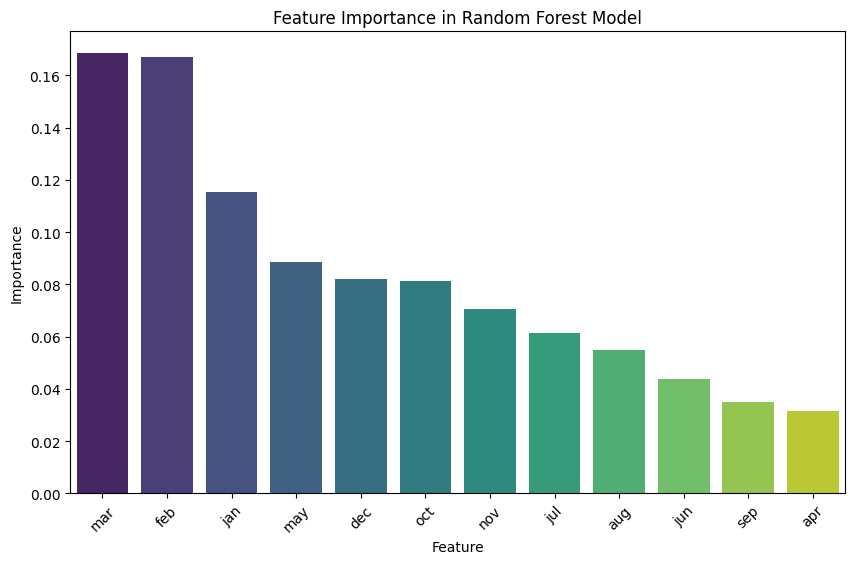

In [15]:
#Feature Importance (Random Forest)
feature_importance = rf_model.feature_importances_
sorted_indices = np.argsort(feature_importance)[::-1]

#Barplot
plt.figure(figsize=(10, 6))
sns.barplot(x=np.array(features)[sorted_indices], y=feature_importance[sorted_indices], palette="viridis")
plt.xlabel("Feature")
plt.ylabel("Importance")
plt.title("Feature Importance in Random Forest Model")
plt.xticks(rotation=45)
plt.show()

In [16]:
# Function to check overfitting & underfitting
def check_overfitting_underfitting(model, model_name, X_train, X_test, y_train, y_test):
    print(f"\nChecking Overfitting/Underfitting for {model_name}...")


    y_train_pred = model.predict(X_train)
    train_accuracy = accuracy_score(y_train, y_train_pred)

    y_test_pred = model.predict(X_test)
    test_accuracy = accuracy_score(y_test, y_test_pred)

    print(f"Training Accuracy: {train_accuracy:.2f}")
    print(f"Test Accuracy: {test_accuracy:.2f}")

    # Detect Overfitting or Underfitting
    if train_accuracy > 0.95 and (train_accuracy - test_accuracy) > 0.10:
        print("Possible Overfitting: High training accuracy but much lower test accuracy.")
    elif train_accuracy < 0.75 and test_accuracy < 0.75:
        print("Possible Underfitting: Both training and test accuracies are low.")
    else:
        print("Model seems well-fitted.")

check_overfitting_underfitting(rf_model, "Random Forest", X_train_scaled, X_test_scaled, y_train, y_test)



Checking Overfitting/Underfitting for Random Forest...
Training Accuracy: 0.99
Test Accuracy: 0.96
Model seems well-fitted.


In [17]:
#sample data
sample_data = pd.DataFrame({'jan': [55],'feb': [60],'mar': [70],'apr': [80],'may': [90],'jun': [100],'jul': [110],'aug': [95],'sep': [85],'oct': [75],'nov': [65],'dec': [50]})
print("Sample Data:")
print(sample_data)

sample_scaled = scaler.transform(sample_data)

predicted_category_encoded = rf_model.predict(sample_scaled)

predicted_category = le.inverse_transform(predicted_category_encoded)

print("\nPredicted AQI Category for the sample data:", predicted_category[0])

Sample Data:
   jan  feb  mar  apr  may  jun  jul  aug  sep  oct  nov  dec
0   55   60   70   80   90  100  110   95   85   75   65   50

Predicted AQI Category for the sample data: Moderate


In [18]:
!pip install streamlit
!pip install streamlit_option_menu

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.3/44.3 kB 2.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.8/9.8 MB 49.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.9/6.9 MB 62.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 79.1/79.1 kB 4.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 829.3/829.3 kB 13.6 MB/s eta 0:00:00


In [19]:
import pickle

# Save the trained model
with open("random_forest_aqi.sav", "wb") as file:
    pickle.dump(rf_model, file)

# Save the scaler
with open("scaler_aqi.pkl", "wb") as file:
    pickle.dump(scaler, file)

# Save the label encoder
with open("label_encoder_aqi.pkl", "wb") as file:
    pickle.dump(le, file)

In [20]:
import joblib

# Save the trained model
joblib.dump(rf_model, "rf_model.pkl")

# Save the scaler (StandardScaler)
joblib.dump(scaler, "scaler.pkl")

# Save the label encoder
joblib.dump(le, "encoder.pkl")

print("Model, Scaler, and Encoder saved successfully!")


Model, Scaler, and Encoder saved successfully!


In [21]:
import pickle
import streamlit as st
import pandas as pd
from streamlit_option_menu import option_menu

# Load the saved model and scaler
rf_model = pickle.load(open("random_forest_aqi.sav", 'rb'))
scaler = pickle.load(open("scaler_aqi.pkl", 'rb'))
label_encoder = pickle.load(open("label_encoder_aqi.pkl", 'rb'))

# Sidebar Navigation
with st.sidebar:
    selected = option_menu("AQI Category Predictor", ["AQI Prediction"], icons=["cloud"], default_index=0)

if selected == "AQI Prediction":
    st.title("Air Quality Index (AQI) Prediction using ML")

    # Creating input fields for each month
    col1, col2, col3, col4 = st.columns(4)

    with col1:
        jan = st.number_input("January AQI", min_value=0, step=1, format="%d")
        may = st.number_input("May AQI", min_value=0, step=1, format="%d")
        sep = st.number_input("September AQI", min_value=0, step=1, format="%d")

    with col2:
        feb = st.number_input("February AQI", min_value=0, step=1, format="%d")
        jun = st.number_input("June AQI", min_value=0, step=1, format="%d")
        oct = st.number_input("October AQI", min_value=0, step=1, format="%d")

    with col3:
        mar = st.number_input("March AQI", min_value=0, step=1, format="%d")
        jul = st.number_input("July AQI", min_value=0, step=1, format="%d")
        nov = st.number_input("November AQI", min_value=0, step=1, format="%d")

    with col4:
        apr = st.number_input("April AQI", min_value=0, step=1, format="%d")
        aug = st.number_input("August AQI", min_value=0, step=1, format="%d")
        dec = st.number_input("December AQI", min_value=0, step=1, format="%d")

    # Code for Prediction
    aqi_prediction = ""

    if st.button("Predict AQI Category"):
        user_input = pd.DataFrame({
            'jan': [jan], 'feb': [feb], 'mar': [mar], 'apr': [apr],
            'may': [may], 'jun': [jun], 'jul': [jul], 'aug': [aug],
            'sep': [sep], 'oct': [oct], 'nov': [nov], 'dec': [dec]
        })

        user_input_scaled = scaler.transform(user_input)
        prediction_encoded = rf_model.predict(user_input_scaled)
        prediction = label_encoder.inverse_transform(prediction_encoded)

        aqi_prediction = f"Predicted AQI Category: {prediction[0]}"

    st.success(aqi_prediction)


2025-03-27 10:28:38.724 WARNING streamlit.runtime.scriptrunner_utils.script_run_context: Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-03-27 10:28:38.735 WARNING streamlit.runtime.scriptrunner_utils.script_run_context: Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-03-27 10:28:38.738 WARNING streamlit.runtime.scriptrunner_utils.script_run_context: Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-03-27 10:28:38.742 WARNING streamlit.runtime.scriptrunner_utils.script_run_context: Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-03-27 10:28:39.084 
  command:

    streamlit run /usr/local/lib/python3.11/dist-packages/colab_kernel_launcher.py [ARGUMENTS]
2025-03-27 10:28:39.087 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when 

In [22]:
!streamlit run /usr/local/lib/python3.11/dist-packages/colab_kernel_launcher.py




  You can now view your Streamlit app in your browser.

  Local URL: http://localhost:8501
  Network URL: http://172.28.0.12:8501
  External URL: http://34.82.197.202:8501

  Stopping...


In [23]:
%%writefile app.py

import streamlit as st
import pandas as pd
import numpy as np
import joblib

# Load the trained model and scaler
model = joblib.load("rf_model.pkl")  # Random Forest Model
scaler = joblib.load("scaler.pkl")   # Standard Scaler
encoder = joblib.load("encoder.pkl") # Label Encoder

st.title("Air Quality Index (AQI) Prediction")

st.write("Enter monthly AQI values to predict the AQI category.")

# Create input fields for each month
months = ['jan', 'feb', 'mar', 'apr', 'may', 'jun', 'jul', 'aug', 'sep', 'oct', 'nov', 'dec']
input_data = []

for month in months:
    value = st.number_input(f"Enter AQI for {month.capitalize()}", min_value=0, max_value=500, step=1)
    input_data.append(value)

# Predict button
if st.button("Predict AQI Category"):
    # Convert to DataFrame
    sample_data = pd.DataFrame([input_data], columns=months)

    # Scale the data
    sample_scaled = scaler.transform(sample_data)

    # Make prediction
    predicted_category_encoded = model.predict(sample_scaled)

    # Decode category
    predicted_category = encoder.inverse_transform(predicted_category_encoded)

    st.success(f"Predicted AQI Category: {predicted_category[0]}")


Writing app.py


In [24]:
!npm install localtunnel


⠙⠹⠸⠼⠴⠦⠧⠇⠏⠋⠙⠹⠸⠼⠴⠦⠧⠇⠏⠋⠙⠹⠸⠼⠴⠦⠧⠇⠏⠋⠙⠹⠸⠼⠴⠦⠧
added 22 packages in 6s
⠧
⠧3 packages are looking for funding
⠧  run `npm fund` for details
⠧

In [ ]:
!streamlit run app.py &>/content/logs.txt & npx localtunnel --port 8501 & curl ipv4.icanhazip.com


34.82.197.202
⠙your url is: https://brown-bobcats-slide.loca.lt
